In [18]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import tifffile

import rasterio
from rasterio.transform import Affine
from rasterio.windows import Window

<AxesSubplot:>

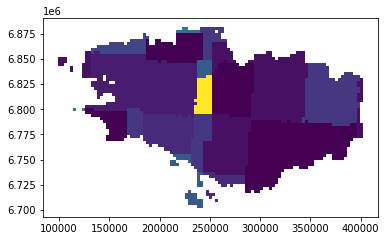

In [2]:
# LOAD DATA AND CREATE GDF
df = pd.read_pickle("/home/simon/CDE_UBS/thesis/data_collection/sen2/closest_dates.pkl")
gdf = gpd.GeoDataFrame(df, geometry=df.geom)
gdf = gdf.set_crs(epsg=2154)
gdf.plot(column="min")

# Try reading only part of image

In [2]:
im_path_sen = '/home/simon/CDE_UBS/thesis/data_collection/small_sen2.tif'
im_path_spot = '/home/simon/CDE_UBS/thesis/data_collection/spot6/ORT_2018_0261_6807_LA93_8Bits.jp2'

In [4]:
def load_window(path,x,y,size):
    import rasterio
    with rasterio.open(path) as src:
        b1 = src.read(1, window=Window(x, y, size, size))
        b2 = src.read(2, window=Window(x, y, size, size))
        b3 = src.read(3, window=Window(x, y, size, size))
        im = np.dstack((b1,b2,b3))
        del b1,b2,b3


    return(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


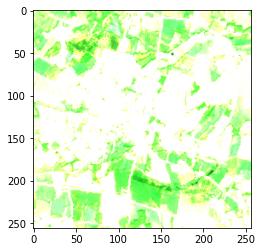

In [5]:
part = load_window(im_path_sen,x=1,y=1,size=256)
print(part.shape)
plt.imshow(part)

In [19]:
im_path_spot = '/home/simon/CDE_UBS/thesis/data_collection/spot6/ORT_2018_0246_6879_LA93_8Bits.jp2'
im_path_spot_2 = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'

In [4]:
def load_window(path,x=0,y=0,size=512,save_result=False,random=False):
    import rasterio, numpy as np
    import random
    
    # open original
    with rasterio.open(path) as src:
        
        # if random window wanted
        if random:
            x = random.randint(0,src.width)
            y = random.randint(0,src.height)
            #print("Random offset -   X:",x," Y:",y)
        
        # define rasterio window
        win = Window(x, y, size, size)
        
        # save meta of original
        src_transform = src.transform
        win_transform = src.window_transform(win)
        aff = win_transform
        profile = src.profile.copy()
        
        # extract windowed bands of original
        b1 = src.read(1, window=win)
        b2 = src.read(2, window=win)
        b3 = src.read(3, window=win)
        
        
        # stack bands to 1 image and delete bands
        im = np.dstack((b1,b2,b3))
        del b1,b2,b3
        
        # test if image extract is valid
        if im.min()<=0:
            raise Exception("Image Window has NoData Values")
        
        # reshape to save
        im = im.transpose(2,0,1)
        
        # check if result should be saved
        if save_result:
            
            # define affine transform
            #newaff = rasterio.Affine(aff.a * im, aff.b, aff.c,aff.d, aff.e * im, aff.f)
            profile.update({
                'driver':'GTiff',
                'dtype': 'float32',
                'height': im.shape[1],
                'width': im.shape[2],
                'transform': aff
                })

            # save file
            with rasterio.open("test_out.tif", 'w',**profile) as dst:
                dst.write(im)

    # return raw array
    #return(im)

In [5]:
load_window(im_path_spot_2,x=100000,y=60000,size=512,save_result=False,random=True)

# Measure Performance

In [21]:
ls = []
import time
for i in range(0,100):
    valid = False
    while valid==False:
        start_time = time.time()
        try:
            a = load_window(im_path_spot_2,size=128,save_result=False,random=True)
            valid = True
        except Exception:
            pass

        elapsed = round(time.time()-start_time,2)
        ls.append(elapsed)
print("Average Time per valid Window Extraction: ",round((sum(ls)/len(ls)),2))

Average Time per valid Window Extraction:  2.48


## Define Data Loader Class

In [5]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random

In [28]:

class Dataset(Dataset):
    def __init__(self,path,width=256,height=256,save_result=False,random_offset=True):
        # extract x and y as lists from DF
        self.path = path
        self.width = width
        self.height = height
        self.save_result = save_result
        self.random_offset = random_offset
 
    def __len__(self):
        # returns length
        return len(self.path)
 
    def __getitem__(self,idx):
        path = self.path
        random_offset = self.random_offset
        # open original
        with rasterio.open(path) as src:

            # if random window wanted
            if random_offset:
                x = random.randint(0,src.width)
                y = random.randint(0,src.height)
                #print("Random offset -   X:",x," Y:",y)

            # define rasterio window
            win = Window(x, y, self.size, size)

            # save meta of original
            src_transform = src.transform
            win_transform = src.window_transform(win)
            aff = win_transform
            profile = src.profile.copy()

            # extract windowed bands of original
            b1 = src.read(1, window=win)
            b2 = src.read(2, window=win)
            b3 = src.read(3, window=win)


            # stack bands to 1 image and delete bands
            im = np.dstack((b1,b2,b3))
            del b1,b2,b3

            # test if image extract is valid
            if im.min()<=0:
                raise Exception("Image Window has NoData Values")

            # reshape to save
            im = im.transpose(2,0,1)

            # check if result should be saved
            if save_result:

                # define affine transform
                #newaff = rasterio.Affine(aff.a * im, aff.b, aff.c,aff.d, aff.e * im, aff.f)
                profile.update({
                    'driver':'GTiff',
                    'dtype': 'float32',
                    'height': im.shape[1],
                    'width': im.shape[2],
                    'transform': aff
                    })

                # save file
                with rasterio.open("test_out.tif", 'w',**profile) as dst:
                    dst.write(im)

        # return raw array
        return(im)

dataset = Dataset(im_path_spot_2)

In [29]:
loader = DataLoader(dataset,batch_size=12, shuffle=True, num_workers=10)

In [30]:
for i in loader:
    print(i)

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-28-d76824597b31>", line 27, in __getitem__
    win = Window(x, y, self.size, size)
  File "/anaconda/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 83, in __getattr__
    raise AttributeError
AttributeError


## DataLoader on Spot6 Images

In [1]:
# import packages
import rasterio

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

In [2]:

files = os.listdir("/home/simon/CDE_UBS/thesis/data_collection/spot6/")

tmp = []
for i in files:
    if i[0] == "O":
        tmp.append("/home/simon/CDE_UBS/thesis/data_collection/spot6/"+i)
files = tmp

In [3]:
class Dataset(Dataset):
    def __init__(self,paths,transform=None):
        # extract x and y as lists from DF
        self.paths = paths
        self.transform = transform
 
    def __len__(self):
        # returns length
        return len(self.paths)
 
    def __getitem__(self,idx):
        with rasterio.open(self.paths[idx]) as src:
            
            #im = read_image(self.paths[idx])
            #im = im.type(torch.DoubleTensor) # change data type to double
            
            b1 = src.read(1) #, window=Window(x, y, size, size))
            b2 = src.read(2) #, window=Window(x, y, size, size))
            b3 = src.read(3) #, window=Window(x, y, size, size))
            im = np.dstack((b1,b2,b3))
        
            # transform if var set
            if self.transform:
                im = self.transform(im)
            return(im)
        
dataset = Dataset(files)
loader = DataLoader(dataset,batch_size=8, shuffle=True, num_workers=10)

In [4]:
%%timeit
dataset.__getitem__(100)


750 ms ± 96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Notes:
- jp2 is unsupported file type for torchread
- if load via torchvision, how to keep georeference?
- load via rasterio too slow?

Needs to:
- Randomly samples spot6 mosaic image, output is spot6 matrix and sen2 matrix (for RGB)
- Recalculate footprint in actual valid data mask

## DataLoader of Spot6 window

In [ ]:
def load_window(path,x_cor=0,y_cor=0,x=0,y=0,size=512):
    import rasterio, numpy as np
    import random
    
    # open original
    with rasterio.open(path) as src:
        
        # define rasterio window
        win = Window(x, y, size, size)
        
        # save meta of original
        src_transform = src.transform
        win_transform = src.window_transform(win)
        aff = win_transform
        profile = src.profile.copy()
        
        # extract windowed bands of original
        b1 = src.read(1, window=win)
        b2 = src.read(2, window=win)
        b3 = src.read(3, window=win)
        
        # stack bands to 1 image and delete bands
        im = np.dstack((b1,b2,b3))
        del b1,b2,b3
        
        # test if image extract is valid
        if im.min()<=0:
            raise Exception("Image Window has NoData Values")
        
        # reshape to save
        im = im.transpose(2,0,1)
        
        # check if result should be saved
        if save_result:
            
            # define affine transform
            #newaff = rasterio.Affine(aff.a * im, aff.b, aff.c,aff.d, aff.e * im, aff.f)
            profile.update({
                'driver':'GTiff',
                'dtype': 'float32',
                'height': im.shape[1],
                'width': im.shape[2],
                'transform': aff
                })

            # save file
            with rasterio.open("test_out.tif", 'w',**profile) as dst:
                dst.write(im)

    # return raw array
    #return(im)

In [10]:
# get location of point

import numpy as np
import rasterio

xs = np.array([99000,6702000])
ys = np.array([99000,6702000])

with rasterio.open(i) as src:
    rows, cols = rasterio.transform.rowcol(src.transform, xs, ys)

In [14]:
rows

[4462000, 60000]

In [31]:
import rasterio

infile = im_path_spot_2
outfile = "out.tif"
coordinates = (
    (279584.5,6792231.5) , # lon, lat of ~centre of Australia
)

# Your NxN window
N = 1000

# Open the raster
with rasterio.open(infile) as dataset:

    # Loop through your list of coords
    for i, (lon, lat) in enumerate(coordinates):

        # Get pixel coordinates from map coordinates
        py, px = dataset.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))

        # Build an NxN window
        window = rasterio.windows.Window(px - N//2, py - N//2, N, N)
        print(window)

        # Read the data in the window
        # clip is a nbands * N * N numpy array
        clip = dataset.read(window=window)

        # You can then write out a new file
        meta = dataset.meta
        meta['width'], meta['height'] = N, N
        meta['transform'] = rasterio.windows.transform(window, dataset.transform)

        with rasterio.open(outfile.format(i), 'w', **meta) as dst:
            dst.write(clip)

Pixel Y, X coords: 59845, 120389
Window(col_off=119889, row_off=59345, width=1000, height=1000)


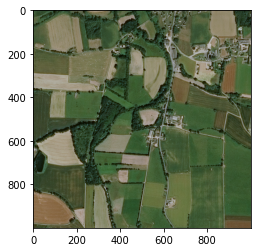

In [32]:
img = plt.imread('out.tif')
plt.imshow(img)